In [1]:
# Run this cell before continuing.
library(tidyverse)
library(dplyr)
library(repr)
library(infer)
library(cowplot)
library(broom)
library(GGally)
library(AER)
library(glmnet)
library(patchwork)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.5.2
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


Loading required package: car

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some


Loading required package: lmtest

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:



In [2]:
data <- read.csv("project_data.csv")
data <- subset(data, select = -c(Browser, Region, TrafficType))
head(data)
nrow(data)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,VisitorType,Weekend,Revenue
,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>,<lgl>,<lgl>
1,0,0,0,0,1,0.000000,0.20000000,0.2000000,0,0,Feb,1,Returning_Visitor,FALSE,FALSE
2,0,0,0,0,2,64.000000,0.00000000,0.1000000,0,0,Feb,2,Returning_Visitor,FALSE,FALSE
3,0,0,0,0,1,0.000000,0.20000000,0.2000000,0,0,Feb,4,Returning_Visitor,FALSE,FALSE
4,0,0,0,0,2,2.666667,0.05000000,0.1400000,0,0,Feb,3,Returning_Visitor,FALSE,FALSE
5,0,0,0,0,10,627.500000,0.02000000,0.0500000,0,0,Feb,3,Returning_Visitor,TRUE,FALSE
6,0,0,0,0,19,154.216667,0.01578947,0.0245614,0,0,Feb,2,Returning_Visitor,FALSE,FALSE


[1] 12330

In [3]:
# For the sake of best visualizing our data I took the liberty of dropping outliers using the Z-Score outlier rule 
# (more than 3 sd's away from the mean is considered an outlier)
# The following is the code for doing so

mean_pr_d <- mean(data$ProductRelated_Duration)
sd_pr_d <- sd(data$ProductRelated_Duration)
cutoff_pr_d = mean_pr_d + 3 * sd_pr_d

mean_i_d <- mean(data$Informational_Duration)
sd_i_d <- sd(data$Informational_Duration)
cutoff_i_d = mean_i_d + 3 * sd_i_d

mean_a_d <- mean(data$Administrative_Duration)
sd_a_d<- sd(data$Administrative_Duration)
cutoff_a_d = mean_a_d + 3 * sd_a_d

##############

data_clean <- data %>%
  filter(ProductRelated_Duration <= cutoff_pr_d) %>%
  filter(Informational_Duration <= cutoff_i_d) %>%
  filter(Administrative_Duration <= cutoff_a_d)

In [4]:
# Visualization 1.1: Durations and interactions

pvi <- ggplot(data, aes(x = ProductRelated_Duration, 
                 y = Informational_Duration, 
                 color = Revenue)) +
  geom_point(alpha = 0.6) +
  labs(
    title = "Product vs Informational Page Duration by Purchase Outcome",
    x = "Product Related Duration (seconds)",
    y = "Informational Duration (seconds)",
    color = "Revenue"
  )

pva <- ggplot(data, aes(x = ProductRelated_Duration, 
                 y = Administrative_Duration, 
                 color = Revenue)) +
  geom_point(alpha = 0.6) +
  labs(
    title = "Product vs Administrative Page Duration by Purchase Outcome",
    x = "Product Related Duration (seconds)",
    y = "Administrative Duration (seconds)",
    color = "Revenue"
  )

avi <- ggplot(data, aes(x = Administrative_Duration, 
                 y = Informational_Duration, 
                 color = Revenue)) +
  geom_point(alpha = 0.6) +
  labs(
    title = "Administrative vs Informational Page Duration by Purchase Outcome",
    x = "Administrative Duration (seconds)",
    y = "Informational Duration (seconds)",
    color = "Revenue"
  )

options(repr.plot.width = 18, repr.plot.height = 6)
vis1 <- pvi | pva | avi

# Explain how we wanted to visualize how they relate to each other...
# Explain choice to do 3 graphs becasue GGPlot cant plot 3d OR install neccesary packages and do 3d

In [5]:
# Visualization 1.1: Durations and interactions

pvi <- ggplot(data_clean, aes(x = ProductRelated_Duration, 
                 y = Informational_Duration, 
                 color = Revenue)) +
  geom_point(alpha = 0.6) +
  labs(
    title = "Product vs Informational Page Duration by Purchase Outcome",
    x = "Product Related Duration (seconds)",
    y = "Informational Duration (seconds)",
    color = "Revenue"
  )

pva <- ggplot(data_clean, aes(x = ProductRelated_Duration, 
                 y = Administrative_Duration, 
                 color = Revenue)) +
  geom_point(alpha = 0.6) +
  labs(
    title = "Product vs Administrative Page Duration by Purchase Outcome",
    x = "Product Related Duration (seconds)",
    y = "Administrative Duration (seconds)",
    color = "Revenue"
  )

avi <- ggplot(data_clean, aes(x = Administrative_Duration, 
                 y = Informational_Duration, 
                 color = Revenue)) +
  geom_point(alpha = 0.6) +
  labs(
    title = "Administrative vs Informational Page Duration by Purchase Outcome",
    x = "Administrative Duration (seconds)",
    y = "Informational Duration (seconds)",
    color = "Revenue"
  )

options(repr.plot.width = 18, repr.plot.height = 6)
vis12 <- pvi | pva | avi

# Explain how we wanted to visualize how they relate to each other...
# Explain choice to do 3 graphs becasue GGPlot cant plot 3d OR install neccesary packages and do 3d

In [6]:
# Visualization 1.2: Raw Visits and interactions

pvi <- ggplot(data, aes(x = ProductRelated, 
                 y = Informational, 
                 color = Revenue)) +
  geom_point(alpha = 0.6) +
  labs(
    title = "Product vs Informational Page Visits by Purchase Outcome",
    x = "Product Related Visits",
    y = "Informational Visits",
    color = "Revenue"
  )

pva <- ggplot(data, aes(x = ProductRelated, 
                 y = Administrative, 
                 color = Revenue)) +
  geom_point(alpha = 0.6) +
  labs(
    title = "Product vs Administrative Page Visits by Purchase Outcome",
    x = "Product Related Visits",
    y = "Administrative Visits",
    color = "Revenue"
  )

avi <- ggplot(data, aes(x = Administrative, 
                 y = Informational, 
                 color = Revenue)) +
  geom_point(alpha = 0.6) +
  labs(
    title = "Administrative vs Informational Page Visits by Purchase Outcome",
    x = "Administrative Visits",
    y = "Informational Visits",
    color = "Revenue"
  )

options(repr.plot.width = 18, repr.plot.height = 6)
vis2 <- pvi | pva | avi

# Explain how we wanted to visualize how they relate to each other...
# Explain choice to do 3 graphs becasue GGPlot cant plot 3d OR install neccesary packages and do 3d


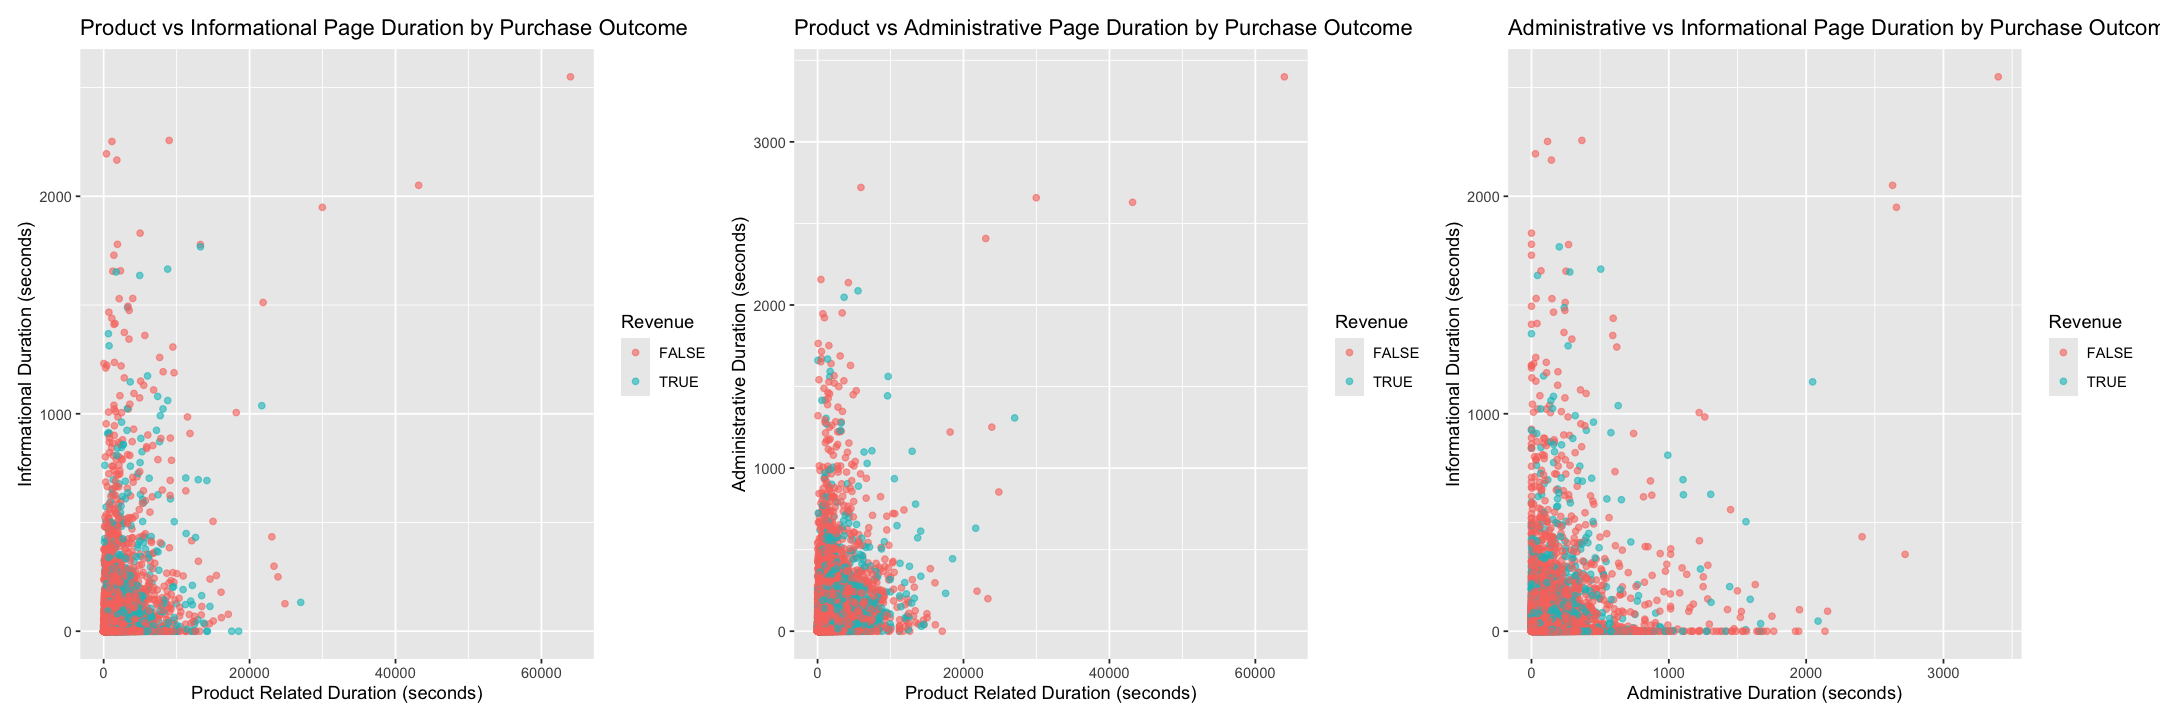

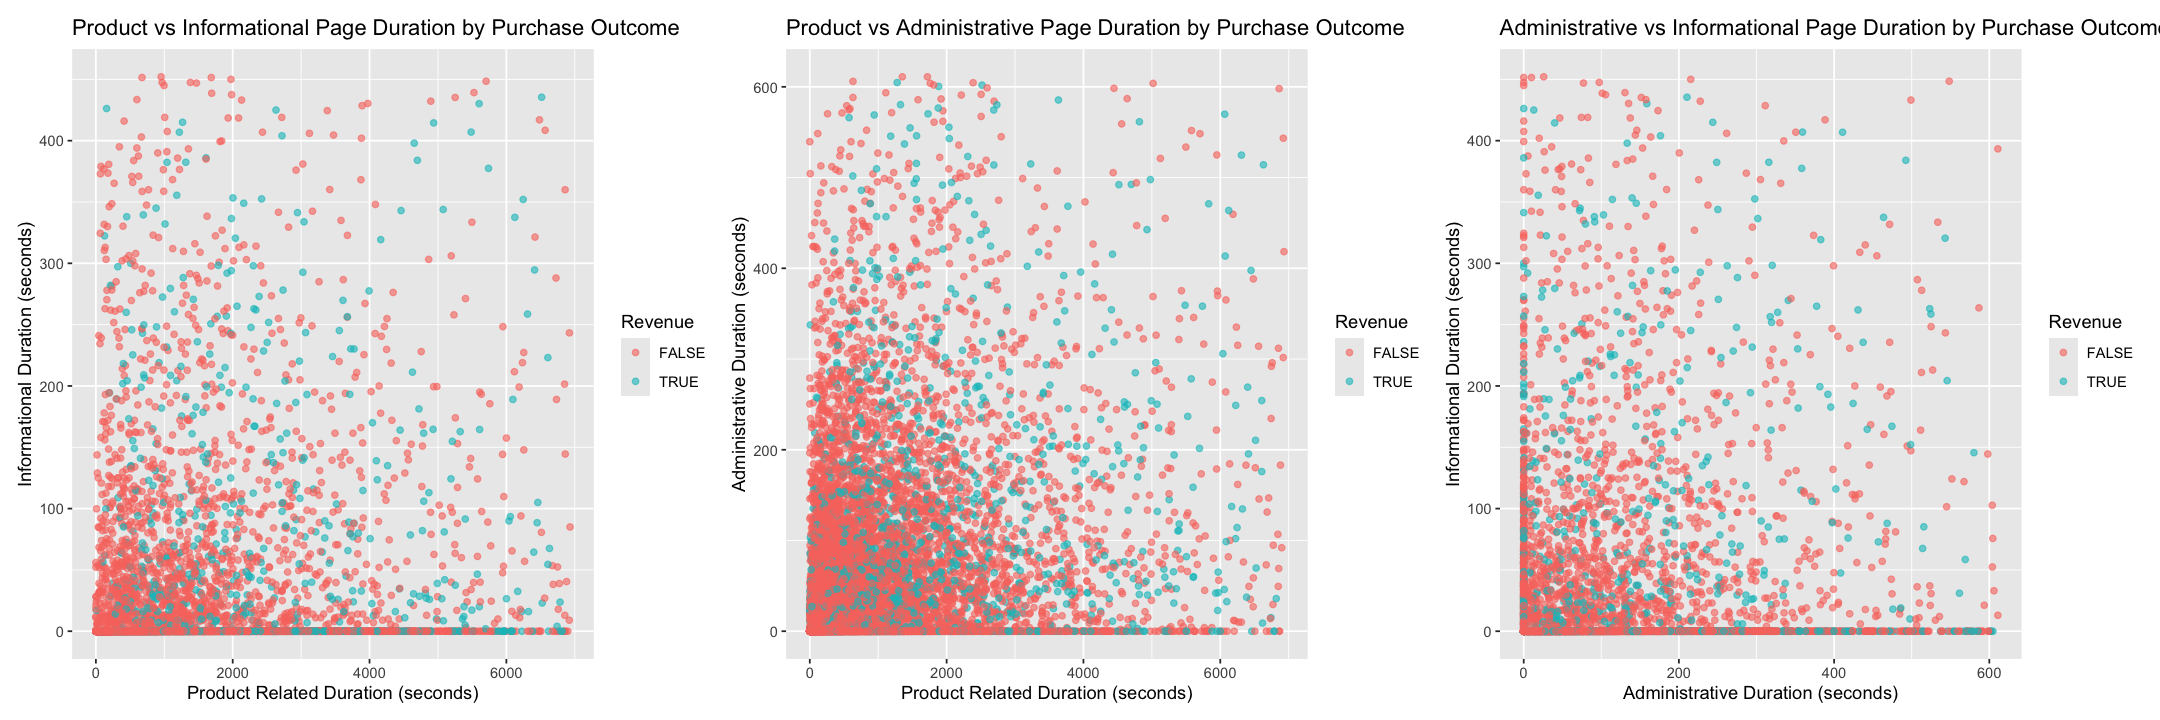

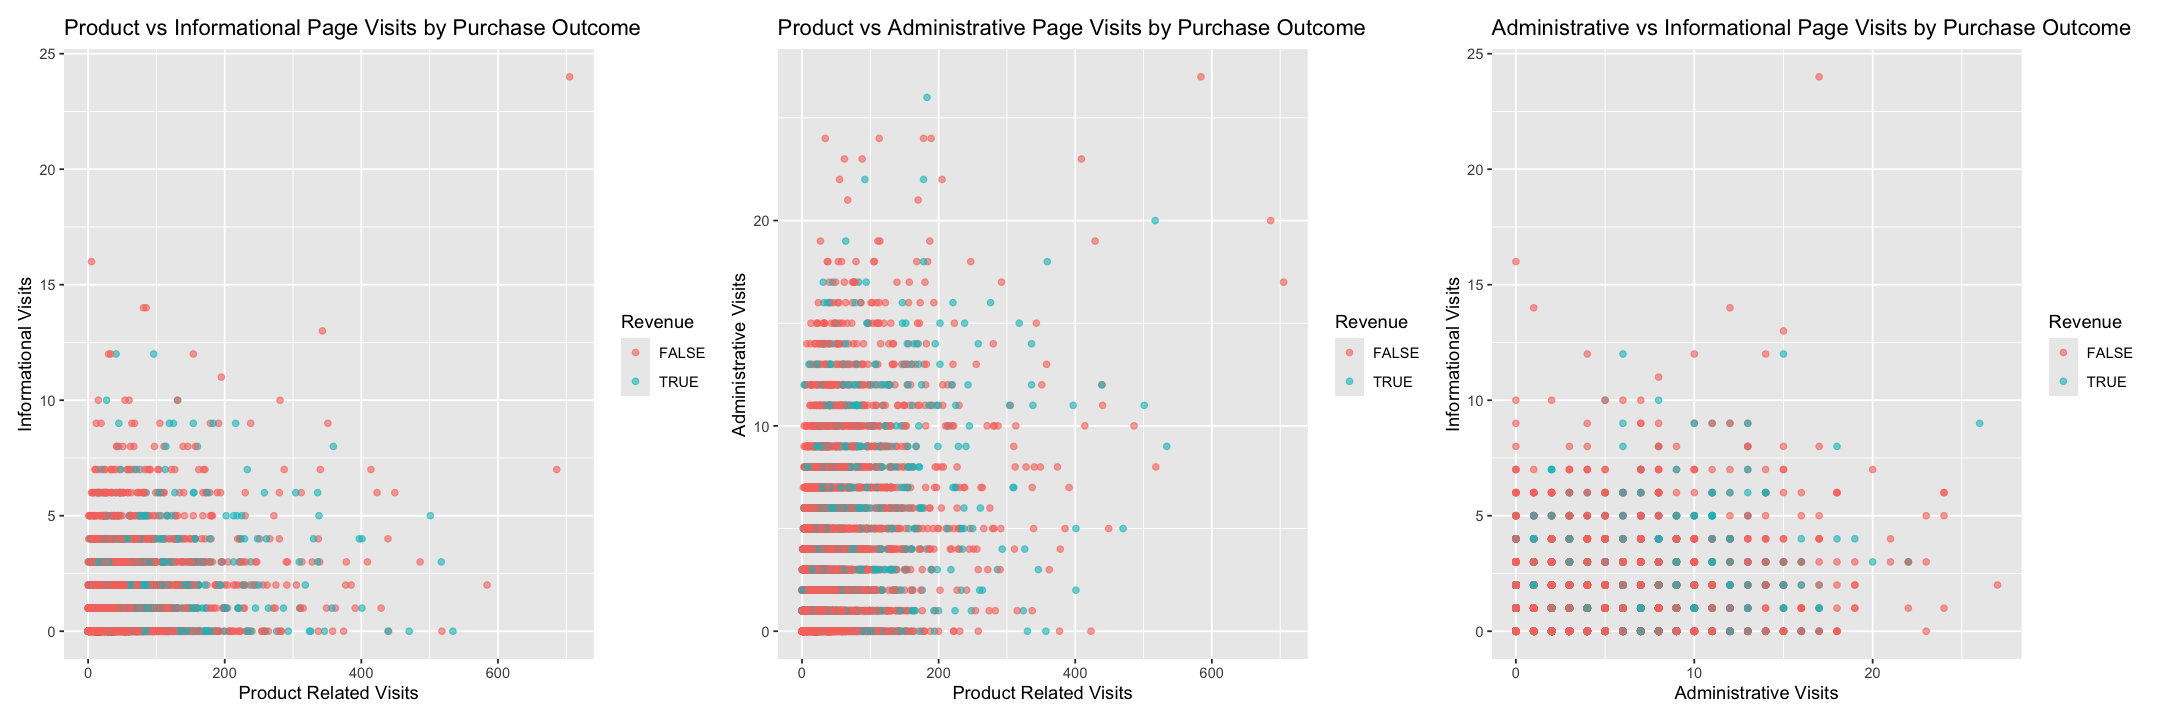

In [7]:
vis1
vis12
vis2

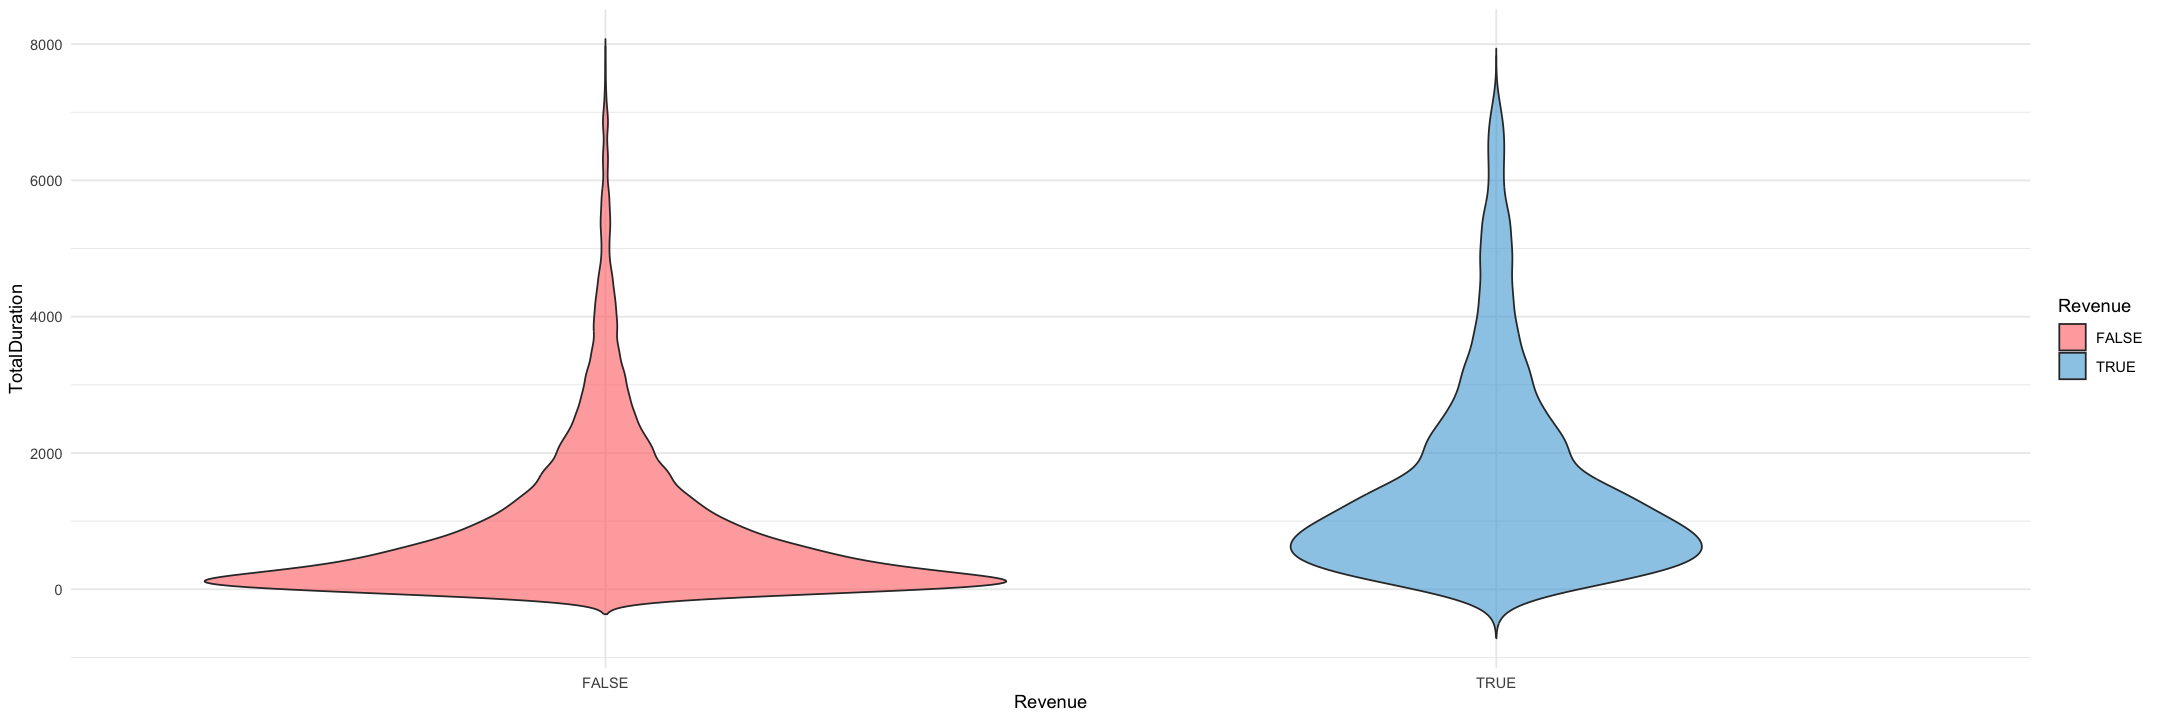

ERROR while rich displaying an object: Error in `geom_point()`:
! Problem while computing aesthetics.
ℹ Error occurred in the 1st layer.
Caused by error:
! object 'TotalDuration' not found

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rp

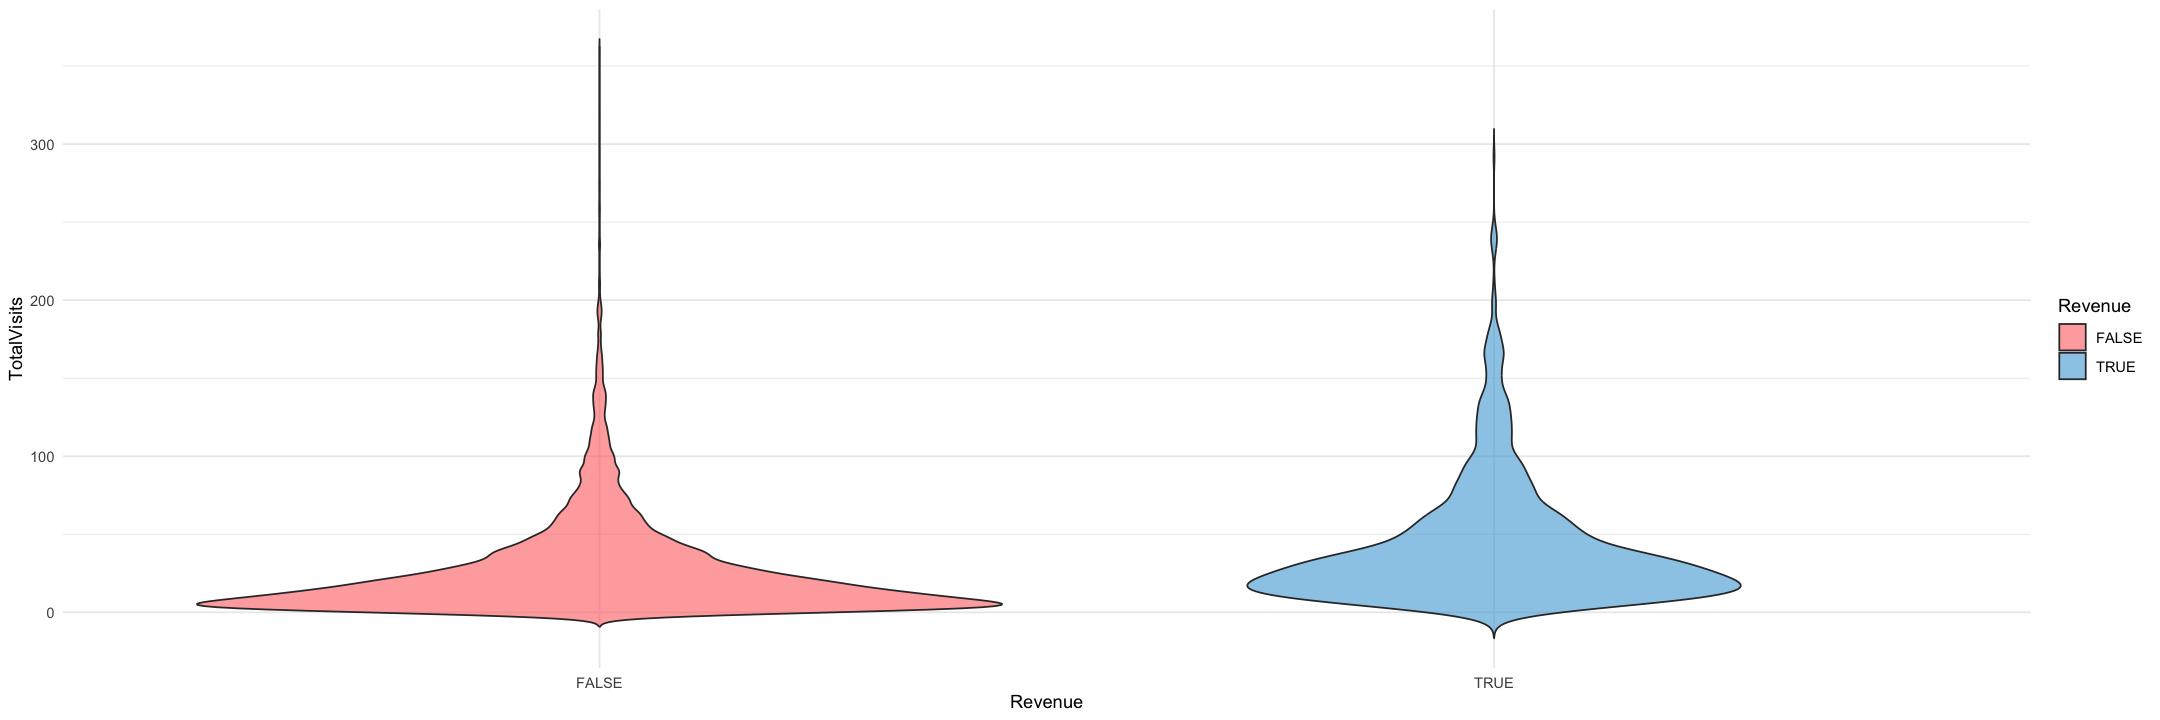

In [13]:
data_clean <- data_clean %>%
    mutate(
        TotalDuration = Administrative_Duration + Informational_Duration + ProductRelated_Duration,
        TotalVisits = Administrative + Informational + ProductRelated
    )

# Violins

ggplot(data_clean, aes(x = Revenue, y = TotalDuration, fill = Revenue)) +
  geom_violin(alpha = 0.6, trim = FALSE) +
  scale_fill_manual(values = c("TRUE" = "#4DA8DA", "FALSE" = "#FF6F6F")) +
  theme_minimal()

ggplot(data_clean, aes(x = Revenue, y = TotalVisits, fill = Revenue)) +
  geom_violin(alpha = 0.6, trim = FALSE) +
  scale_fill_manual(values = c("TRUE" = "#4DA8DA", "FALSE" = "#FF6F6F")) +
  theme_minimal()

# Against each other

ggplot(data, aes(x = TotalDuration, 
                 y = TotalVisits, 
                 color = Revenue)) +
  geom_point(alpha = 0.6) +
  labs(
    title = "Total Duration vs Total Page Visits by Purchase Outcome",
    x = "Total Duration on Site (Seconds)",
    y = "Sub Page Visits",
    color = "Revenue"
  )